# 🎨 Semantic Segmentation (U-Net & DeepLabV3)

Welcome! In our previous notebooks, we've tackled classification (one label per image) and object detection (bounding boxes). Now, we're diving into **Semantic Segmentation**.

**The Goal:** To classify **every single pixel** in an image.

* **Classification:** "This image contains a cat."
* **Detection:** "There is a cat at [x, y, w, h]."
* **Segmentation:** "These *exact* pixels belong to 'cat,' and these pixels belong to 'grass,' and these pixels belong to 'sky'."



This is a "dense prediction" task, as we need a prediction for every pixel. Today, we'll cover two major architectures:

1.  **U-Net:** The "gold standard" for biomedical image segmentation, and a brilliant, elegant architecture. It's perfect for building from scratch.
2.  **DeepLabV3:** A state-of-the-art model from Google that introduces powerful concepts like **atrous (dilated) convolutions** for high-resolution, wide-context mapping.

## 1. Setup: Libraries

We'll need `torch`, `torchvision`, and `matplotlib`. We'll also be using the `OxfordIIITPet` dataset, which is conveniently built into `torchvision`.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from torchvision.transforms import v2 as T

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import requests
import time
import io

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 2. Part 1: U-Net (Building From Scratch)

The U-Net was introduced in 2015 for segmenting cells in medical images. While initially designed for biomedical applications, its architecture proved so effective that it became the standard backbone for general semantic segmentation.

### 2.1. The "Fully Convolutional" Philosophy

To understand U-Net, we first need to understand why standard classification networks (like VGG or ResNet) fail at segmentation.

**The Problem with Dense Layers:**

In a standard classifier, the network ends with **Fully Connected (Dense)** layers. To feed data into a dense layer, you must **flatten** the input feature map (e.g., transforming a `7x7x512` volume into a single `1x25088` vector).
* **Consequence:** You destroy all **spatial information**. The network knows *that* a cat is in the image, but it has completely forgotten *where* the cat is (top-left? bottom-right?).

**The Solution: Fully Convolutional Networks (FCNs)**

For segmentation, we need an output map that matches the input resolution (`H x W`). Therefore, we simply **remove the dense layers**. The entire network consists only of convolutions, pooling, and upsampling layers. This preserves spatial coordinates throughout the entire process. U-Net is a prime example of an FCN.

### 2.2. The U-Net Architecture: A Deep Dive

The architecture resembles the letter "U" and consists of three critical components.

#### 1. The Encoder (Contracting Path)
This is the left side of the "U". It acts like a standard feature extractor (backbone).
* **Operation:** It applies `Conv3x3` layers followed by `MaxPooling`.
* **Effect:** As the image goes deeper, the **spatial resolution decreases** (downsampling), but the **number of channels increases**.
* **Purpose:** To capture the **"What"** (Context). By shrinking the image, the filters cover a larger percentage of the original image (Receptive Field), allowing the network to understand high-level semantic features (e.g., "this texture looks like a pet").

#### 2. The Decoder (Expanding Path)
This is the right side of the "U".
* **Operation:** It uses **Transposed Convolutions** (or UpSampling) to increase the image size.
* **Effect:** The **spatial resolution increases** back to the original size.
* **Purpose:** To capture the **"Where"** (Localization). It tries to project the learned features back onto the original pixel grid.

#### 3. The Critical Component: Skip Connections
If we just had an Encoder and a Decoder, the output would be blurry. Why? Because multiple pooling operations in the encoder result in a massive loss of fine-grained spatial detail.

**The Fix:** U-Net introduces **Skip Connections**.
* **How it works:** Before each pooling step in the Encoder, we save a copy of the feature map. In the corresponding step of the Decoder, we **concatenate** this high-resolution encoder map with the upsampled decoder map.
* **Why it works:** The decoder gets a "cheat sheet." It receives the semantic context from the bottleneck (deep features) *and* the precise boundary information from the encoder (shallow features). This allows it to draw sharp, pixel-perfect segmentation masks.

### 2.3. The Magic of 1x1 Convolutions

You will notice the final layer of the U-Net is a **1x1 Convolution**. This is a very specific and important tool in deep learning.

**What is it?**

A standard convolution (e.g., 3x3) looks at a patch of neighboring pixels to understand spatial patterns. A **1x1 convolution** has a kernel size of 1. It only looks at **one pixel at a time**, but it looks across **all channels**.

**What does it do?**
1.  **Channel Transformation:** It acts like a tiny Fully Connected layer applied independently to every single pixel. It takes the `C_in` input channels and maps them to `C_out` output channels using a learned weight vector.
2.  **Dimensionality Reduction/Projection:** In our U-Net decoder, the final feature map might have 64 channels (`[Batch, 64, H, W]`). However, our task is to classify each pixel into one of `N` classes (e.g., 3 classes: Pet, Outline, Background).
3.  **The Classification Step:** We apply a 1x1 convolution with `N` filters. This projects the 64-channel feature vector at each pixel down to a 3-channel vector (the **logits**).
    * Input: `[Batch, 64, H, W]`
    * 1x1 Conv (3 filters): `[Batch, 3, H, W]`
    * Output: Each pixel now has 3 numbers, representing the raw scores for "Pet," "Outline," and "Background."

This allows us to perform **pixel-wise classification** efficiently while keeping the network fully convolutional.

---

### 2.4. U-Net Implementation

Now let's translate this theory into PyTorch code. We'll define a helper `DoubleConv` block (since U-Net repeats the `Conv-BatchNorm-ReLU` pattern twice at every step) and then the full architecture.

In [ ]:
class DoubleConv(nn.Module):
    """(Convolution -> BatchNorm -> ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        # 1. Encoder (Contracting Path)
        self.inc = DoubleConv(n_channels, 64)

        self.down1_pool = nn.MaxPool2d(2)
        self.down1_conv = DoubleConv(64, 128)

        self.down2_pool = nn.MaxPool2d(2)
        self.down2_conv = DoubleConv(128, 256)

        self.down3_pool = nn.MaxPool2d(2)
        self.down3_conv = DoubleConv(256, 512)

        self.down4_pool = nn.MaxPool2d(2)
        self.down4_conv = DoubleConv(512, 1024)

        # 2. Decoder (Expanding Path)
        # We use Transpose Convolutions to up-sample
        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(1024, 512) # 512 from skip + 512 from up

        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(512, 256)

        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(256, 128)

        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv4 = DoubleConv(128, 64)

        # 3. Final 1x1 Convolution
        # This maps the 64-channel feature map to n_classes (e.g., 3)
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        # -- Encoder --
        x1 = self.inc(x)
        x2 = self.down1_pool(x1)
        x2 = self.down1_conv(x2)
        x3 = self.down2_pool(x2)
        x3 = self.down2_conv(x3)
        x4 = self.down3_pool(x3)
        x4 = self.down3_conv(x4)
        x5 = self.down4_pool(x4)
        x5 = self.down4_conv(x5)

        # -- Decoder --
        x = self.up1(x5)
        # *** The Skip Connection ***
        # We crop x4 to match x's size if they differ
        # (This isn't needed here due to padding, but it's in the original paper)
        x = torch.cat([x4, x], dim=1) # Concat along channel dim
        x = self.conv1(x)

        x = self.up2(x)
        x = torch.cat([x3, x], dim=1)
        x = self.conv2(x)

        x = self.up3(x)
        x = torch.cat([x2, x], dim=1)
        x = self.conv3(x)

        x = self.up4(x)
        x = torch.cat([x1, x], dim=1)
        x = self.conv4(x)

        # Final output
        logits = self.outc(x)
        return logits

# --- Test the model with a dummy input ---
model_unet = UNet(n_channels=3, n_classes=3).to(device)
dummy_input = torch.randn(2, 3, 256, 256).to(device) # Batch=2, C=3, H=256, W=256
output = model_unet(dummy_input)

print("U-Net created successfully.")
print(f"Input shape: {dummy_input.shape}")
print(f"Output shape: {output.shape}") # [B, n_classes, H, W]


U-Net created successfully.
Input shape: torch.Size([2, 3, 256, 256])
Output shape: torch.Size([2, 3, 256, 256])


### 2.5. The Dataset: Oxford-IIIT Pet

This dataset is perfect for us. It's built into `torchvision`, it's not too big (37 classes), and it provides segmentation masks.

The masks have pixel values:
* `1`: Pet
* `2`: Pet outline
* `3`: Background

We'll simplify this to a 3-class problem: `0: Pet`, `1: Outline`, `2: Background`.

Loaded 3680 training images and 3669 test images.
Image shape: torch.Size([3, 128, 128])
Mask shape: torch.Size([128, 128])
Mask unique values: tensor([0, 1, 2])


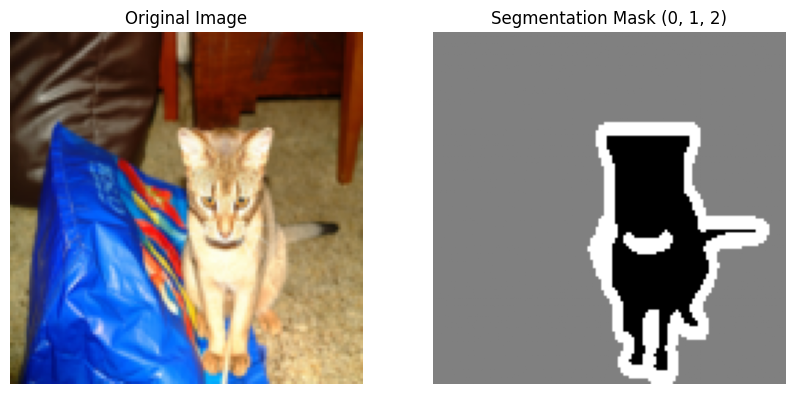

In [ ]:
# --- Data Preprocessing ---
# This is the most critical part for segmentation!
IMG_SIZE = 128

class PetDataset(Dataset):
    def __init__(self, root, split, target_types='segmentation'):
        self.dataset = datasets.OxfordIIITPet(root=root,
                                              split=split,
                                              target_types=target_types,
                                              download=True)

        # Image transforms
        self.img_transforms = T.Compose([
            T.Resize((IMG_SIZE, IMG_SIZE)),
            T.ToImage(), # Convert PIL to tensor
            T.ToDtype(torch.float32, scale=True), # Normalize to [0, 1]
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        # Mask transforms
        self.mask_transforms = T.Compose([
            T.Resize((IMG_SIZE, IMG_SIZE), interpolation=T.InterpolationMode.NEAREST),
            T.ToImage() # Convert PIL to tensor
        ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, mask = self.dataset[idx]

        img = self.img_transforms(img)
        mask = self.mask_transforms(mask)

        # **Crucial:** Masks from this dataset are 1, 2, 3.
        # We subtract 1 to make them 0, 1, 2 (for CrossEntropyLoss)
        mask = (mask - 1).to(torch.long)

        # Squeeze the channel dim from the mask
        mask = mask.squeeze(0) # [1, H, W] -> [H, W]

        return img, mask

# Create datasets and dataloaders
train_dataset = PetDataset(root='./data', split='trainval')
# Note: For a real project, split 'trainval' into 'train' and 'val'
test_dataset = PetDataset(root='./data', split='test')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Loaded {len(train_dataset)} training images and {len(test_dataset)} test images.")

# --- Visualize a sample ---
img, mask = train_dataset[5]
print(f"Image shape: {img.shape}")
print(f"Mask shape: {mask.shape}")
print(f"Mask unique values: {torch.unique(mask)}")

# We need to un-normalize the image for plotting
def unnormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    # Apply inverse normalization and then clamp values to [0, 1]
    unnormalized_tensor = T.Normalize(-mean/std, 1/std)(tensor)
    return torch.clamp(unnormalized_tensor, 0, 1)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(unnormalize(img).permute(1, 2, 0))
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(mask, cmap='gray')
ax[1].set_title('Segmentation Mask (0, 1, 2)')
ax[1].axis('off')
plt.show()

### 2.6. Training the U-Net

Now we write the training loop.

**The Loss Function:** We must use **Cross-Entropy Loss**.
* **Model Output (`output`):** `[Batch_Size, Num_Classes, H, W]`
    * e.g., `[32, 3, 128, 128]`
* **Target Mask (`mask`):** `[Batch_Size, H, W]`
    * e.g., `[32, 128, 128]`

The loss function `nn.CrossEntropyLoss` is designed to handle exactly this. For each pixel, it compares the 3-channel "logit" vector from the output with the single "class ID" (0, 1, or 2) from the target.

In [ ]:
# 1. Init model, optimizer, and loss
N_CLASSES = 3 # 0: Pet, 1: Outline, 2: Background
model = UNet(n_channels=3, n_classes=N_CLASSES).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# 2. Training function
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    for i, (imgs, masks) in enumerate(loader):
        imgs, masks = imgs.to(device), masks.to(device)

        optimizer.zero_grad()

        outputs = model(imgs) # [B, C, H, W]

        loss = criterion(outputs, masks) # masks are [B, H, W]

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(loader)

# 3. Evaluation function (just for loss, not mIoU)
def evaluate_epoch(model, loader, criterion, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for imgs, masks in loader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            epoch_loss += loss.item()
    return epoch_loss / len(loader)

# 4. The Training Loop
N_EPOCHS = 10 # 10-15 should be enough to see it working
print(f"Starting training for {N_EPOCHS} epochs...")

for epoch in range(N_EPOCHS):
    start_time = time.time()

    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss = evaluate_epoch(model, test_loader, criterion, device)

    end_time = time.time()
    epoch_mins = (end_time - start_time) // 60
    epoch_secs = (end_time - start_time) % 60

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins:.0f}m {epoch_secs:.0f}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {val_loss:.3f}')

print("Training finished.")

Starting training for 10 epochs...
Epoch: 01 | Time: 1m 39s
	Train Loss: 0.649
	 Val. Loss: 0.551
Epoch: 02 | Time: 1m 36s
	Train Loss: 0.513
	 Val. Loss: 0.489
Epoch: 03 | Time: 1m 36s
	Train Loss: 0.448
	 Val. Loss: 0.439
Epoch: 04 | Time: 1m 35s
	Train Loss: 0.401
	 Val. Loss: 0.416
Epoch: 05 | Time: 1m 36s
	Train Loss: 0.366
	 Val. Loss: 0.404
Epoch: 06 | Time: 1m 36s
	Train Loss: 0.344
	 Val. Loss: 0.391
Epoch: 07 | Time: 1m 36s
	Train Loss: 0.328
	 Val. Loss: 0.369
Epoch: 08 | Time: 1m 36s
	Train Loss: 0.304
	 Val. Loss: 0.384
Epoch: 09 | Time: 1m 36s
	Train Loss: 0.291
	 Val. Loss: 0.323
Epoch: 10 | Time: 1m 35s
	Train Loss: 0.282
	 Val. Loss: 0.351
Training finished.


### 2.7. Inference and Visualization (U-Net)

Let's see how our trained model does! We'll grab a few images from the test set and plot the original, the ground truth, and our prediction.

Visualizing U-Net predictions...


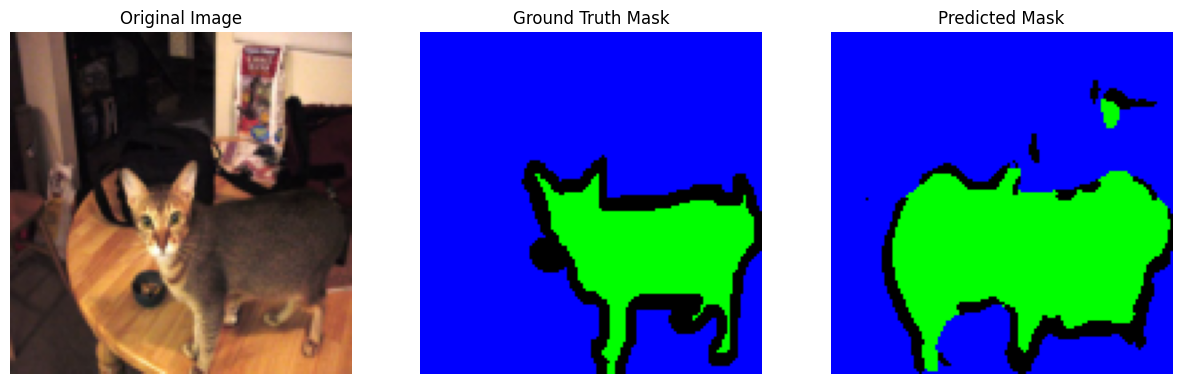

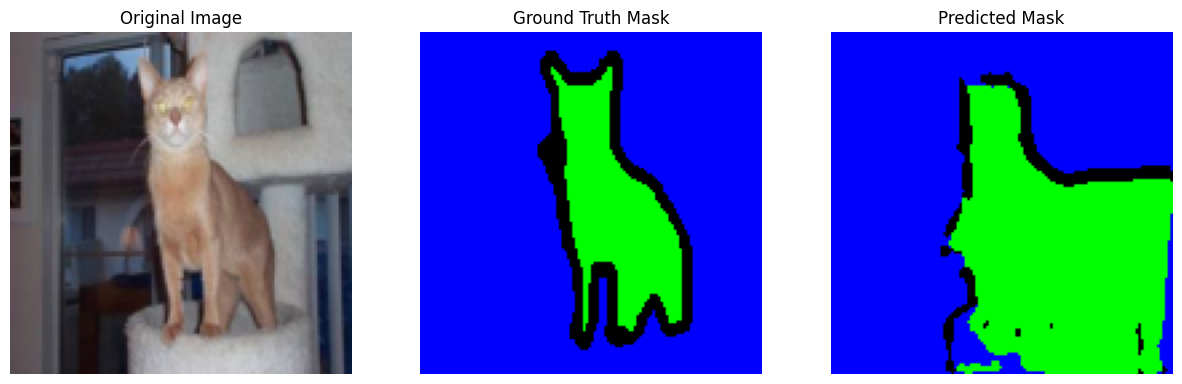

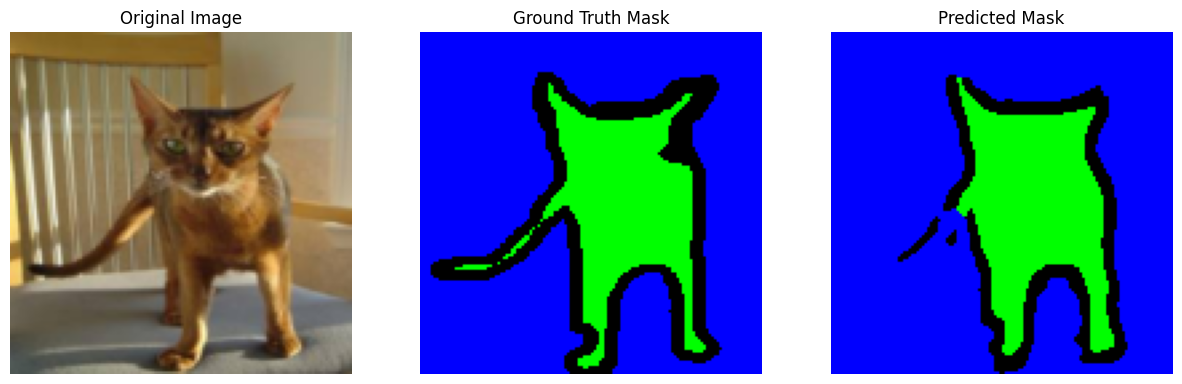

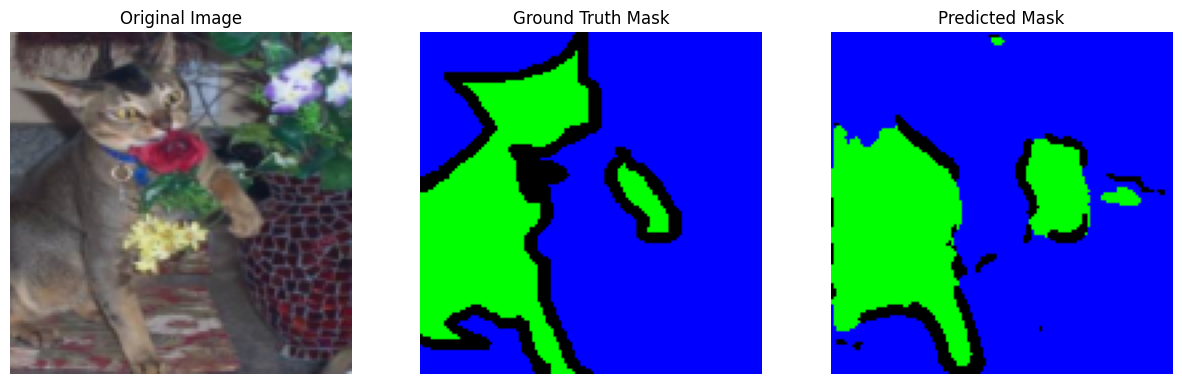

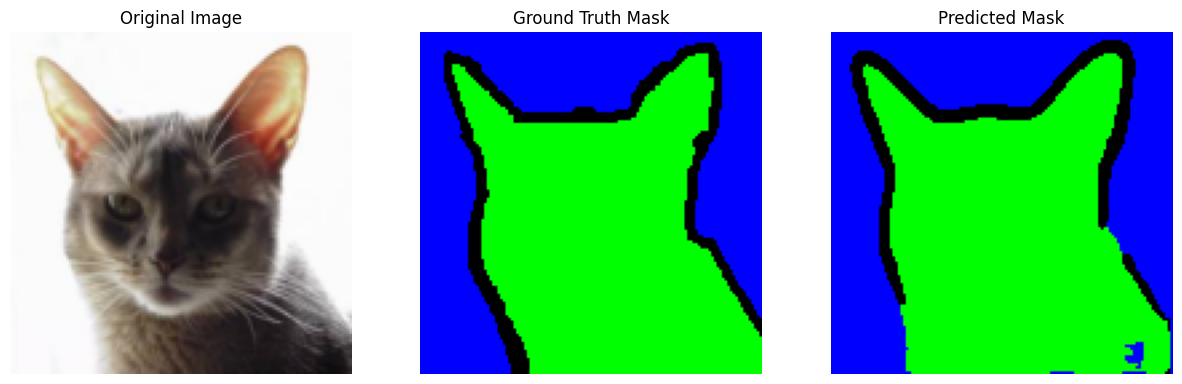

In [ ]:
def visualize_predictions(model, loader, device, num_samples=5):
    model.eval()

    # Simple color map for our 3 classes
    # 0: Pet (Green), 1: Outline (Blue), 2: Background (Black)
    colors = torch.tensor([[0, 1, 0], [0, 0, 1], [0, 0, 0]], dtype=torch.float32)

    def colorize_mask(mask):
        # mask is [H, W] with values 0, 1, 2
        rgb_mask = colors[mask.cpu()].permute(2, 0, 1) # [H, W, 3] -> [3, H, W]
        return rgb_mask

    samples_shown = 0
    with torch.no_grad():
        for imgs, true_masks in loader:
            imgs, true_masks = imgs.to(device), true_masks.to(device)

            # Get model output
            outputs = model(imgs) # [B, C, H, W]

            # Get the predicted class (0, 1, or 2) for each pixel
            pred_masks = torch.argmax(outputs, dim=1) # [B, H, W]

            # Move to CPU for plotting
            imgs_cpu = [unnormalize(img) for img in imgs.cpu()]
            true_masks_cpu = [colorize_mask(mask) for mask in true_masks.cpu()]
            pred_masks_cpu = [colorize_mask(mask) for mask in pred_masks.cpu()]

            for i in range(imgs.size(0)):
                if samples_shown >= num_samples:
                    return

                fig, ax = plt.subplots(1, 3, figsize=(15, 5))

                ax[0].imshow(imgs_cpu[i].permute(1, 2, 0))
                ax[0].set_title('Original Image')
                ax[0].axis('off')

                ax[1].imshow(true_masks_cpu[i].permute(1, 2, 0))
                ax[1].set_title('Ground Truth Mask')
                ax[1].axis('off')

                ax[2].imshow(pred_masks_cpu[i].permute(1, 2, 0))
                ax[2].set_title('Predicted Mask')
                ax[2].axis('off')

                plt.show()
                samples_shown += 1

# --- Run visualization ---
print("Visualizing U-Net predictions...")
visualize_predictions(model, test_loader, device, num_samples=5)

## 3. Part 2: DeepLabV3

Our U-Net works! But modern architectures have pushed segmentation even further. The **DeepLab** series from Google is a dominant force.

We won't build it from scratch, but we must understand its key innovations.

### 💡 The Concept: Atrous (Dilated) Convolution

**The Problem:** Standard CNNs (like our U-Net encoder) repeatedly use Max-Pooling. This shrinks the image (e.g., 256x256 -> 128x128 -> 64x64). This is great for classification (it saves computation), but terrible for segmentation (we *lose* high-resolution information).

**The Solution:** Use **atrous (or dilated) convolutions**.

An atrous convolution has a "rate" (`r`). It inserts `r-1` gaps into the filter.



* A standard 3x3 filter (`r=1`) sees a 3x3 patch.
* An atrous 3x3 filter with `r=2` sees a 5x5 patch (while still only having 9 parameters!).
* An atrous 3x3 filter with `r=4` sees a 9x9 patch.

This allows the model to have a **massive receptive field** (it can "see" a huge part of the image) *without* ever needing to down-sample. It can learn about large objects while keeping the feature map at a high resolution.

### 💡 The Concept: Atrous Spatial Pyramid Pooling (ASPP)

**The Problem:** Objects in an image exist at different scales (a person up close vs. a person far away). How do we capture all of them?

**The Solution:** Use **ASPP**. This block runs several atrous convolutions with *different rates* (e.g., r=6, r=12, r=18) *in parallel* on the same feature map. It also adds a global average pooling branch (to see the whole image).



It's like looking at the image with "binoculars" at 4 different zoom levels simultaneously, then merging all that information. This makes DeepLabV3 incredibly robust to object scale.

### 3.1. Practical Example: Pre-trained DeepLabV3

Let's use `torchvision` to run a pre-trained DeepLabV3 (trained on PASCAL VOC, 21 classes) on a sample image.

In [ ]:
# 1. Load the pre-trained DeepLabV3 model
model_deeplab = models.segmentation.deeplabv3_resnet101(
    weights=models.segmentation.DeepLabV3_ResNet101_Weights.DEFAULT
)
model_deeplab.eval()
model_deeplab.to(device)
print("DeepLabV3 model loaded.")

# 2. Load a sample image
img_url = "https://images.pexels.com/photos/159897/pexels-photo-159897.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1"
response = requests.get(img_url)
response.raise_for_status() # Raise an exception for bad status codes
input_image = Image.open(io.BytesIO(response.content)).convert("RGB")

# 3. Get the model's specific transforms
deeplab_transforms = models.segmentation.DeepLabV3_ResNet101_Weights.DEFAULT.transforms()
input_tensor = deeplab_transforms(input_image).unsqueeze(0) # Add batch dim
input_tensor = input_tensor.to(device)

# 4. Run inference
with torch.no_grad():
    output = model_deeplab(input_tensor)

# The output is an OrderedDict. The 'out' key holds the logits.
output = output['out'] # [1, 21, H, W]
print(f"DeepLabV3 output shape: {output.shape}")

# 5. Get the predicted class for each pixel
pred_mask = torch.argmax(output.squeeze(), dim=0).cpu().numpy() # [H, W]
print(f"Prediction mask shape: {pred_mask.shape}")

DeepLabV3 model loaded.
DeepLabV3 output shape: torch.Size([1, 21, 520, 924])
Prediction mask shape: (520, 924)


### 3.2. Visualizing DeepLabV3 Output

The output is a 2D array where each pixel has a value from 0 to 20, corresponding to the 21 classes of the PASCAL VOC dataset. We need to create a color map to see it.

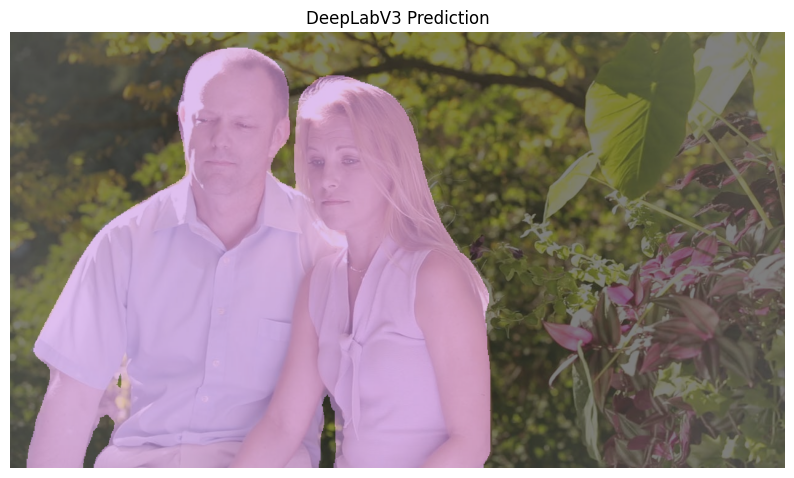

Classes found in image:
  - background
  - person


In [ ]:
# PASCAL VOC 21 Classes (20 classes + 1 background)
# (We'll only define a few for this demo)
VOC_CLASSES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]

# Create a color map (RGB)
# This is a simplified version of the PASCAL VOC color map
palette = torch.tensor([
    [0, 0, 0],       # 0: background
    [128, 0, 0],     # 1: aeroplane
    [0, 128, 0],     # 2: bicycle
    [128, 128, 0],   # 3: bird
    [0, 0, 128],     # 4: boat
    [128, 0, 128],   # 5: bottle
    [0, 128, 128],   # 6: bus
    [128, 128, 128], # 7: car
    [64, 0, 0],      # 8: cat
    [192, 0, 0],     # 9: chair
    [64, 128, 0],    # 10: cow
    [192, 128, 0],   # 11: diningtable
    [64, 0, 128],    # 12: dog
    [192, 0, 128],   # 13: horse
    [64, 128, 128],  # 14: motorbike
    [192, 128, 224], # 15: person
    [0, 64, 0],      # 16: pottedplant
    [128, 64, 0],    # 17: sheep
    [0, 192, 0],     # 18: sofa
    [128, 192, 0],   # 19: train
    [0, 64, 128]     # 20: tvmonitor
], dtype=torch.uint8)

# --- Colorize the predicted mask ---
rgb_mask = palette[pred_mask].numpy()

# --- Overlay mask on the original image ---
def show_segmented_image(image, mask, alpha=0.5):
    # Resize mask to match image
    mask_pil = Image.fromarray(mask).resize(image.size, resample=Image.NEAREST)
    mask_arr = np.array(mask_pil)

    # Blend image and mask
    blended = (1 - alpha) * np.array(image) + alpha * mask_arr
    blended = blended.astype(np.uint8)

    plt.figure(figsize=(10, 7))
    plt.imshow(blended)
    plt.axis('off')
    plt.title("DeepLabV3 Prediction")
    plt.show()

    # Show what classes were found
    found_classes = np.unique(pred_mask)
    print("Classes found in image:")
    for class_id in found_classes:
        print(f"  - {VOC_CLASSES[class_id]}")

show_segmented_image(input_image, rgb_mask)

## 5. Conclusion

We've successfully explored semantic segmentation from two angles:

1.  **U-Net (From Scratch):** We saw how a clever **Encoder-Decoder + Skip Connection** architecture can be built from scratch and trained to produce high-resolution masks. Its elegance and simplicity make it a must-know.
2.  **DeepLabV3 (Pre-trained):** We learned the state-of-the-art concepts of **Atrous Convolutions** and **ASPP**, which achieve massive receptive fields and multi-scale understanding *without* losing resolution.

**Next Steps:**
Semantic segmentation has one "problem": it labels *all* cars as "car." It can't tell the difference between "car 1," "car 2," and "car 3."

To solve this, we need **Instance Segmentation**—a model that can find every *instance* of an object and give it its own unique mask. That's exactly what we'll build in the next notebook with **Mask R-CNN**.